# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import cv2
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import seaborn as sns
sns.set_style("whitegrid")

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))


sign_classes, classes_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

print("Number of training examples =", n_train)
print("Number of validation examples =", len(X_valid))
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


# Do some Sanity Checking
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

Plot the number of examples of each sign in the training set and testing set
-----------------------------------------------------

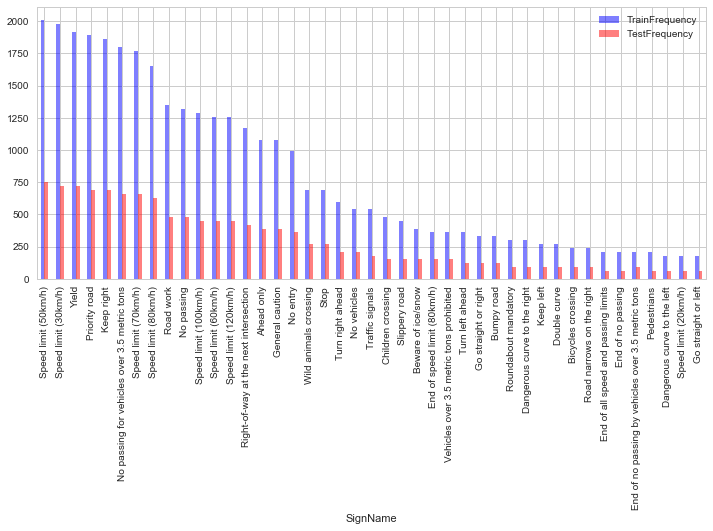

In [4]:
#load the the Sign Names
signnames = pd.read_csv("signnames.csv")

# Build dataframe for training data
traindata = pd.DataFrame(y_train, columns=["ClassId"])
traindata = traindata.merge(signnames, how="left", left_on="ClassId", right_on="ClassId")
traindata = traindata.rename(columns={'ClassId': 'TrainFrequency'})
# Build dataframe for testing data
testdata = pd.DataFrame(y_test, columns=["ClassId"])
testdata = testdata.merge(signnames, how="left", left_on="ClassId", right_on="ClassId")
testdata["TestFrequency"] = 1

# Groupby for Test summary
datacount = traindata.groupby(["SignName"]).count()
datacount = datacount.join(testdata.groupby(["SignName"])["TestFrequency"].count())
datacount = datacount.sort_values(by="TrainFrequency", ascending=False)
#print(datacount.index)
# Plot it
datacount.plot.bar(figsize=(12, 5), color=['b','r'], width=.5, alpha=0.5)
plt.show()

Helper-Function for plotting images
===================================

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
import matplotlib.gridspec as gridspec

def plot_images(start_idx, end_idx):
    gs = gridspec.GridSpec(6, 4, top=1., bottom=-0.3, right=2., left=0., hspace=0.3, wspace=0.2)
    
    i = 0
    
    # Get indexes of each example from each class
    for sign_type in datacount[start_idx:end_idx].index:
        idxs = traindata[traindata["SignName"] == sign_type].index.tolist()
        ax = plt.subplot(gs[i])
        ax.imshow(X_train[idxs[100]])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(sign_type)
        
        i+=1
      

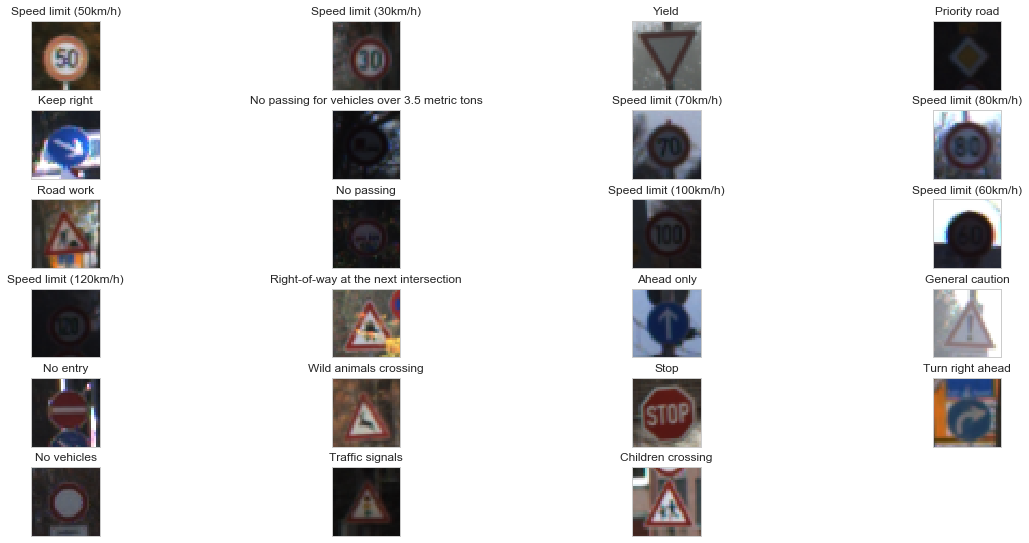

In [8]:
plot_images(0,23)

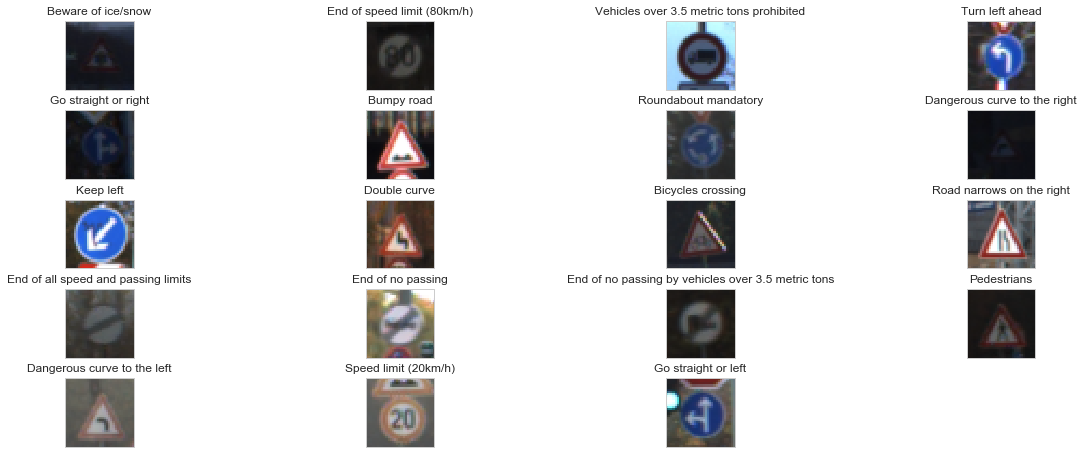

In [10]:
plot_images(24, 43)


~ Exploratory Data Analysis
==========================

- After examining the provided training dataset for the distribution of the various classes, the classes were found to be highly imbalanced indicating the need to generate new data for the under-represented classes such as class-19, class-27, class-37 to name a few.


- The images differ significantly in terms of contrast and brightness. As a result, we will need to apply some kind of data processing to improve feature extraction.


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

* For Data Pre-processing, I decided to apply [Contrast Limited Adaptive Histogram Equalization](http://www.cs.utah.edu/~sujin/courses/reports/cs6640/project2/clahe.html) algorithm in the [Lab color space](https://en.wikipedia.org/wiki/Lab_color_space) to do the contrast enhancement.

* In addition to contrast enhancement, I normalized the images between 0-1.

* As Pierre Sermanent and Yann LeCun mentioned in their [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) paper, using color channels didn't seem to improve things a lot and by using grayscale images they still got high accuracy. Nonetheless, I chose to experiment with colored images.

* The following functions from [TFLearn Library](http://tflearn.org/data_augmentation/#image-augmentation) were used for **image augmentation**. The reason behind the image augmentation is the fact that our original training set was highly imbalanced. 


In [ ]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.

Helper-functions for Image Augmentation
===============================================

I've decided to generate augmented data through three techniques by adding the following trasnformations.
- Rotation (-10 , 10 )
- Shifting (-5 , 5 )
- Shearing (-5 , 5 )
Then for each image, I generated 5 additional images with 5 by randomly rotating, shifting and shearing it.


In [11]:
from sklearn.utils import shuffle
import scipy
from scipy import linalg
import scipy.ndimage as ndi
from skimage import transform, exposure
from skimage.util import random_noise
import skimage

In [12]:
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

In [13]:
def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x

In [14]:
def shear(x, intensity=0.3, is_random=False, row_index=0, col_index=1, channel_index=2, fill_mode='nearest', cval=0.):
    if is_random:
        shear = np.random.uniform(-intensity, intensity)
    else:
        shear = intensity
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x[0].shape[row_index], x[0].shape[col_index]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)


In [15]:
def shift(x, wrg=0.2, hrg=0.2, is_random=False, row_index=0, col_index=1, channel_index=2,
                 fill_mode='nearest', cval=0.):
    h, w = x[0].shape[row_index], x[0].shape[col_index]
    if is_random:
        tx = np.random.uniform(-hrg, hrg) * h
        ty = np.random.uniform(-wrg, wrg) * w
    else:
        tx, ty = hrg * h, wrg * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)

In [16]:
def rotation(x, rg=10, is_random=False, row_index=0, col_index=1, channel_index=2,
                    fill_mode='nearest', cval=0.):
    if is_random:
        theta = np.pi / 180 * np.random.uniform(-rg, rg)
    else:
        theta = np.pi /180 * rg
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x[0].shape[row_index], x[0].shape[col_index]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    results = []
    for data in x:
        results.append( apply_transform(data, transform_matrix, channel_index, fill_mode, cval))
    return np.asarray(results)

In [17]:
def multitransform(x):
    x=rotation(x, is_random=True)
    x=shift(x, is_random=True)
    x=shear(x, is_random=True)
    return x

In [18]:
def randomly_distort(x,y):
    for i in range(43):
        print(i)
        indexes = y == i
        #count = np.sum(indexes)
        ex= 5 #int(2200/count)
        x_train_sample = x[indexes]
        y_train_sample = y[indexes]
        x_extra = []
        y_extra = []
        for i in range(ex):
            x_extra = multitransform(x_train_sample)
            x = np.concatenate((x, x_extra))
            y = np.concatenate((y, y_train_sample))
    return x,y

In [19]:
X_train, y_train = randomly_distort(X_train, y_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [20]:
# Training set size after Image Augmentation
print(X_train.shape, y_train.shape)

(208794, 32, 32, 3) (208794,)


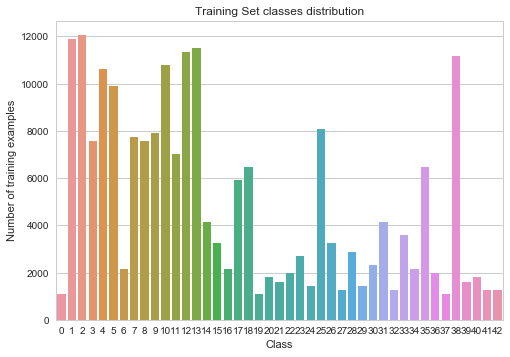

In [21]:
# Plot the number of examples of each sign in the training set after Image augmentation
sns.countplot(y_train)
plt.ylabel('Number of training examples')
plt.xlabel('Class')
plt.title('Training Set classes distribution')
plt.show()

In [22]:
# Compute the max and min observations

dist = np.histogram(y_train, bins=n_classes)
classes = dist[1]
counts = dist[0]
max_count = max(counts)
min_count = min(counts)

print("Max observations for a class:", max_count)
print("Min observations for a class:", min_count)

Max observations for a class: 12060
Min observations for a class: 1080


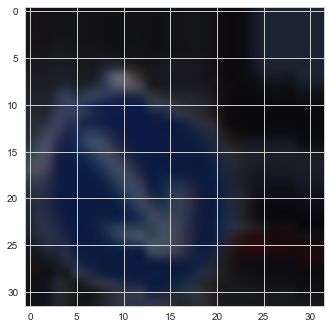

In [26]:
## Show the above samples with preprocessing applied
plt.imshow(X_train[200000],  interpolation = 'spline16')
plt.show()

Helper-function for normalization, CLAHE algorithm 
===================================================================

[[[ 0.95294118  0.9254902   0.93333333]
  [ 0.8745098   0.85490196  0.86666667]
  [ 0.85882353  0.85490196  0.8745098 ]
  ..., 
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]]

 [[ 0.95294118  0.9254902   0.93333333]
  [ 0.8745098   0.85490196  0.86666667]
  [ 0.85882353  0.85490196  0.8745098 ]
  ..., 
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]]

 [[ 0.95294118  0.9254902   0.93333333]
  [ 0.8745098   0.85490196  0.86666667]
  [ 0.85882353  0.85490196  0.8745098 ]
  ..., 
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]
  [ 0.93333333  0.98823529  1.        ]]

 ..., 
 [[ 0.55686275  0.5372549   0.54901961]
  [ 0.5372549   0.5372549   0.56078431]
  [ 0.6627451   0.67843137  0.7372549 ]
  ..., 
  [ 0.74509804  0.74117647  0.76078431]
  [ 0.79215686  0.78431373  0.80784314]
  [ 0.79215686  0.78431373  0.80784

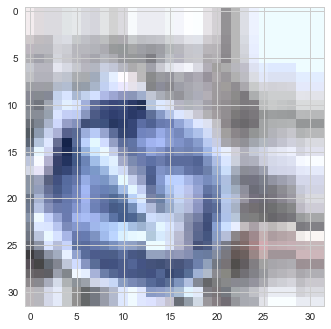

In [27]:
from sklearn.preprocessing import scale

def preprocess(image):
    image=cv2.convertScaleAbs(image)

    # Convert to LAB colorspace
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    limg = cv2.merge((cl,a,b))
    
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    final=final/final.max()

    return final

ft=preprocess(X_train[200000])
plt.figure()

plt.imshow(ft)
print(ft)

print("Preprocessing done.")

In [28]:
X_train_orig, X_valid_orig, X_test_orig = X_train, X_valid,  X_test

In [ ]:
train_X = np.array([preprocess(image) for image in X_train], dtype=np.float32)
valid_X = np.array([preprocess(image) for image in X_valid], dtype=np.float32)
test_x = np.array([preprocess(image) for image in X_test], dtype=np.float32)

Shuffle the data
=================

In [46]:
from sklearn.utils import shuffle

X_valid, y_valid = shuffle(valid_X, y_valid)

In [47]:
X_train, y_train = shuffle(train_X, y_train)

In [48]:
X_test, y_test = test_x, y_test

### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [54]:
EPOCHS = 10
BATCH_SIZE = 128
mu = 0
sigma = 0.1

activation = tf.nn.relu

def linear(x, W, b):
    return tf.add(tf.matmul(x, W), b)

def conv2d(x, W, b, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    return tf.nn.bias_add(x, b)

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

def maxpool2d(x, k=2, s=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, s, s, 1],
        padding='SAME')

def gen_keep_prob():
    return tf.placeholder(tf.float32, name="keep_prob")


In [55]:

def LeNet_dropout(x, keep_prob):

    weights = {
        'conv1' : tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma)),
        'conv2' : tf.Variable(tf.truncated_normal(shape=(9, 9, 6, 16), mean = mu, stddev = sigma)),
        'flat3' : tf.Variable(tf.truncated_normal(shape=(1600, 400), mean = mu, stddev = sigma)),
        'flat4' : tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma)),
        'flat5' : tf.Variable(tf.truncated_normal(shape=(120, 43), mean = mu, stddev = sigma))
    }
    biases = {
        'conv1' : tf.Variable(tf.zeros(6)),
        'conv2' : tf.Variable(tf.zeros(16)),
        'flat3' : tf.Variable(tf.zeros(400)),
        'flat4' : tf.Variable(tf.zeros(120)),
        'flat5' : tf.Variable(tf.zeros(43))
    }

    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1 = conv2d(x, weights['conv1'], biases['conv1'])

    # Activation
    conv1 = activation(conv1)

    # Dropout
    conv1 = dropout(conv1, keep_prob)

    # Layer 2: Convolutional. Input = 28x28x6. Output = 10x10x16.
    conv2 = conv2d(conv1, weights['conv2'], biases['conv2'], strides=2)

    # Activation.
    conv2 = activation(conv2)

    # Dropout
    conv2 = dropout(conv2, keep_prob)

    # Flatten. Input = 10x10x16. Output = 1600.
    flat3 = tf.reshape(conv2, [-1, weights['flat3'].get_shape().as_list()[0]])

    # Layer 3: Fully Connected. Input = 1600. Output = 400.
    flat3 = linear(flat3, weights['flat3'], biases['flat3'])

    # Activation.
    flat3 = activation(flat3)

    # Layer 4: Fully Connected. Input = 400. Output = 120.
    flat4 = linear(flat3, weights['flat4'], biases['flat4'])

    # Activation.
    flat4 = activation(flat4)

    # Layer 5: Fully Connected. Input = 120. Output = 43.
    logits = linear(flat4, weights['flat5'], biases['flat5'])

    return logits

In [56]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [57]:
rate = 0.001

logits = LeNet_dropout(x, keep_prob) 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [58]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [59]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
  
    print("Training with {} input images...".format(num_examples))
    print()
    for i in range(EPOCHS):       
    
        start_time = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.6})

        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        end_time = time.time()
        time_diff = end_time - start_time
        
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
        print()      

    saver.save(sess, './lenet_dropout_traffic')
    print("Model saved")

Training with 208794 input images...

EPOCH 1 ...
Train Accuracy = 0.959
Validation Accuracy = 0.854
Time usage: 0:15:38

EPOCH 2 ...
Train Accuracy = 0.985
Validation Accuracy = 0.917
Time usage: 0:12:26

EPOCH 3 ...
Train Accuracy = 0.990
Validation Accuracy = 0.922
Time usage: 0:12:42

EPOCH 4 ...
Train Accuracy = 0.993
Validation Accuracy = 0.927
Time usage: 0:12:34

EPOCH 5 ...
Train Accuracy = 0.996
Validation Accuracy = 0.940
Time usage: 0:12:34

EPOCH 6 ...
Train Accuracy = 0.996
Validation Accuracy = 0.930
Time usage: 0:12:30

EPOCH 7 ...
Train Accuracy = 0.998
Validation Accuracy = 0.942
Time usage: 0:12:20

EPOCH 8 ...
Train Accuracy = 0.998
Validation Accuracy = 0.957
Time usage: 0:13:22

EPOCH 9 ...
Train Accuracy = 0.998
Validation Accuracy = 0.950
Time usage: 0:13:48

EPOCH 10 ...
Train Accuracy = 0.998
Validation Accuracy = 0.945
Time usage: 0:12:07

Model saved


In [60]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.941


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

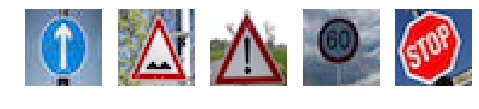

In [63]:
import matplotlib.image as mpimg

dir = 'test-signs/'

test_images = np.zeros((5, 32, 32, 3))

for i in range(5):
    image = mpimg.imread(dir + "image%d.jpg" % (i+1))
    test_images[i] = preprocess(image)
    plt.subplot(1, 5, i+1)
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    
test_images = test_images.astype(np.float32)

### Predict the Sign Type for Each Image

Predicted labes are [35 22 18  7 14]


The Predicted class/sign names:



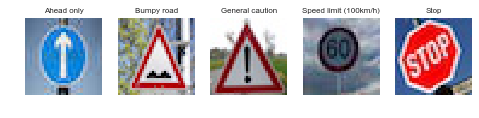

In [68]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    loader = tf.train.import_meta_graph("./lenet_dropout_traffic.meta")
    loader.restore(sess, tf.train.latest_checkpoint("."))
    predicted_logits = sess.run(logits, feed_dict={x:test_images, keep_prob:1.})
    
predicted_labels = np.argmax(predicted_logits, axis=1)
print("Predicted labes are {}\n\n".format(predicted_labels))
print("The Predicted class/sign names:\n")

for i in range(5):
    image = mpimg.imread(dir + "image{}.jpg".format(i+1))
    plt.subplot(1, 5, i+1)
    plt.title(signnames["SignName"][predicted_labels[i]], fontsize=8)
    
    plt.imshow(image.astype('uint8'))
    plt.axis('off')
    


### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

1. Image-1 is identified **(correctly)**
2. Image-2 is identified **(correctly)**
3. Image-3 is identified **(correctly)**
4. Image-4 is identified **(incorrectly)**
5. Image-5 is identified **(correctly)**

The model predicted 4 out 5 signs correctly, which is 80% accuracy.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

Ahead only , Go straight or right , Go straight or left , Turn right ahead , Roundabout mandatory
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Bumpy road , Slippery road , Bicycles crossing , Pedestrians , Road work
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
General caution , Traffic signals , Road narrows on the right , Pedestrians , Road work
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Speed limit (100km/h) , Speed limit (80km/h) , Speed limit (120km/h) , Speed limit (60km/h) , Stop
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Stop , Speed limit (80km/h) , Speed limit (30km/h) , No entry , Road work
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


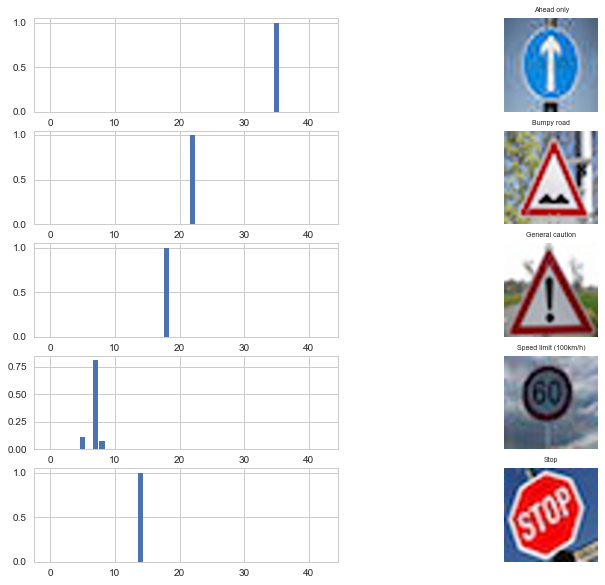

In [71]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


softmax_probabilites = softmax(predicted_logits)
v,inp = tf.nn.top_k(predicted_logits, k=43)
sess=tf.InteractiveSession()

iev = inp.eval()
vev = softmax(v.eval())

for i in range(5):
    print(signnames["SignName"][ iev[i][0] ],',', signnames["SignName"][ iev[i][1] ], ',',
          signnames["SignName"][ iev[i][2] ], ',', signnames["SignName"][ iev[i][3]], ',', 
          signnames["SignName"][ iev[i][4] ] )  
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

fig = plt.figure(figsize=(12, 10))
width = 1.5
x_vals = range(43)


k=0
for i in range(5):
    image = mpimg.imread(dir + "image%d.jpg" % (i+1) )
    k=k+1
    ax = fig.add_subplot(5,2,k)
    ax.bar(iev[i][:], vev[i][:])
    
    k=k+1
    plt.subplot(5, 2, k)
    plt.title(signnames["SignName"][predicted_labels[i]], fontsize=7)
    plt.imshow(image.astype('uint8'), interpolation='spline16')
    plt.axis('off')
    

plt.show()

In [87]:
vev[3][0:5]

array([  8.10057819e-01,   1.15538359e-01,   7.12526366e-02,
         2.56904704e-03,   4.61886375e-04], dtype=float32)

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [72]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [73]:
outputFeatureMap(test_images[1], weights['conv1'], activation_min=-1, activation_max=-1 ,plt_num=1)

NameError: name 'weights' is not defined

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 